# 目的
- エンゼルの出現確率を購入者毎に予測する
- 独立に予測した結果と階層モデルで予測した結果を比較する

In [1]:
import os, sys
import numpy as np
import pandas as pd
import scipy.stats as stats

import itertools
import math

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm


In [2]:
color_palette = 'gray' # deep, gray
sns.set(context='notebook', style='darkgrid', palette=color_palette, 
        font='sans-serif', font_scale=1.5, color_codes=False, rc=None)
markers = ['.', "x", "s", "+", "v", "p", "^", "<", ">", "1", "2", "3", "4"]
n_markers = len(markers)
color_list = sns.color_palette()
linestyles = ['-', '--', '-.', ':']

# データの取得
- 期間:2017/12/10~2019/12/29
  - エンゼル２倍キャンペーン対象商品を除く
- 対象者:3人（A, B, C）

In [3]:
data = pd.read_csv('data/choco_data.csv')
tastes = pd.read_csv('data/choco_tastes.csv')
data = data.merge(tastes, left_on=['taste'], right_on=['id'])
data.head()

,measure_date,best_before,taste,buyer,silver,id,name,name_en,spec
0,2017-12-10,2018-09-01,1,A,0,1,いちご,strawberry,25
1,2017-12-10,2018-09-01,1,A,0,1,いちご,strawberry,25
2,2017-12-10,2018-09-01,1,A,0,1,いちご,strawberry,25
3,2017-12-10,2018-09-01,1,A,0,1,いちご,strawberry,25
4,2017-12-10,2018-09-01,1,A,0,1,いちご,strawberry,25


In [4]:
pd.merge(
    data.groupby('buyer').count()[['id']], 
    data.groupby('buyer').sum()[['silver']], 
    left_index=True, right_index=True)

,id,silver
buyer,,
A,345,16
B,96,7
C,93,3


In [5]:
pd.merge(
    data.groupby(['taste', 'name']).count()[['id']], 
    data.groupby(['taste', 'name']).sum()[['silver']], 
    left_index=True, right_index=True)

,,id,silver
taste,name,,
0,ピーナツ,356,18
1,いちご,57,2
4,甘酒,9,2
6,カスタード,4,0
7,パチパチ,9,0
8,ラムネ,3,0
9,パンプキン,4,0
11,ミルクキャラメル,16,0
12,チョコバナナ,43,2


# エンゼル出現確率の推論
4つのアプローチで出現確率の推論を行う。

1. 最尤推定
2. 対象者毎に独立に推論
3. 対象者毎に依存関係を持たせる（階層モデル）
4.  「運」の量を示す変数を追加

In [6]:
buyer = data['buyer'].values
buyer_idx = pd.Categorical(data['buyer']).codes
buyer_cat = pd.Categorical(data['buyer']).categories
data['buyer_idx'] = buyer_idx
lst_buyer = list(set(buyer_idx))
n_buyer = len(lst_buyer)
print(buyer_cat)
print(set(buyer_idx))

Index(['A', 'B', 'C'], dtype='object')
{0, 1, 2}


In [7]:
total_counts = data.groupby(['buyer_idx']).count()['silver'].values
angel_counts = data.query('silver > 0').groupby(['buyer_idx']).count()['silver'].values

print('total_count : {}'.format(total_counts))
print('angel_count : {}'.format(angel_counts))


total_count : [345  96  93]
angel_count : [16  7  3]


## 頻度（最尤推定）を計算

In [8]:
theta_mle = angel_counts/total_counts

df_mle = data.groupby('buyer').count()[['id']].rename(columns={'id':'購入数'})
df_mle['MLE'] = theta_mle
df_mle

,購入数,MLE
buyer,,
A,345,0.046377
B,96,0.072917
C,93,0.032258


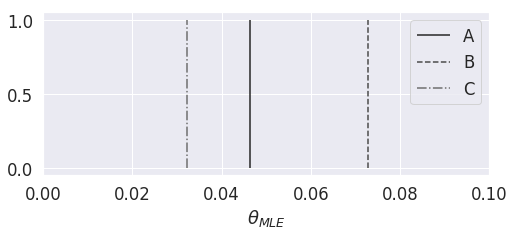

In [9]:
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1, 1)
for idx in np.arange(0, n_buyer):
    ax.vlines(theta_mle[idx], 0, 1, 
              linestyle=linestyles[idx%len(linestyles)], 
              colors=color_list[idx%len(color_list)], label=buyer_cat[idx])
ax.set_xlim((0.0, 0.1))
ax.set_xlabel('$\\theta_{MLE}$')
ax.legend()
plt.savefig('buyer_effect_mle.png')

## 対象者ごとに独立に推論

### 推論

In [10]:
with pm.Model() as model_sep:
    theta = pm.Beta('theta', alpha=1, beta=1, shape=n_buyer)
    angel = pm.Binomial('angel', n=total_counts[lst_buyer], p=theta[lst_buyer], observed=angel_counts[lst_buyer])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
100%|██████████| 5500/5500 [00:04<00:00, 1251.33it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/tok41/workspace/tech_book/env_tb/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12d337940>,
      dtype=object)

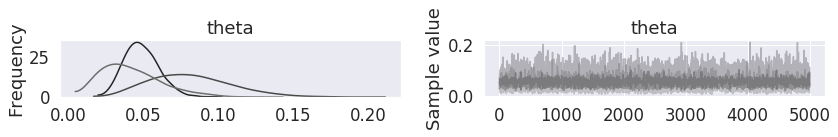

In [11]:
n_sample = 5000
with model_sep:
    trace_sep = pm.sample(n_sample, chains=1, random_seed=100)
pm.traceplot(trace_sep)

### 事後分布の可視化

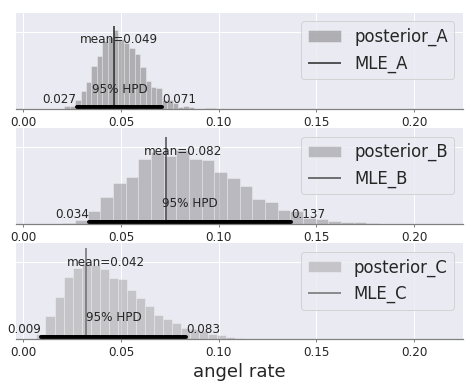

In [12]:
fig = plt.figure(figsize=(8, 6))
ax = fig.subplots(3, 1, sharex=True, sharey=True)

for idx in np.arange(0, n_buyer):
    pm.plot_posterior(trace_sep['theta'][:,idx], 
                      color=color_list[idx%len(color_list)], alpha=0.3, 
                      ax=ax[idx], label='posterior_{}'.format(buyer_cat[idx]))
    xmin, xmax, ymin, ymax = ax[idx].axis()
    ax[idx].vlines(theta_mle[idx], ymin, ymax, 
                   colors=color_list[idx%len(color_list)], 
                   label='MLE_{}'.format(buyer_cat[idx]))
    ax[idx].legend()
ax[idx].set_xlabel('angel rate')

plt.savefig('buyer_effect_iso_post.png')

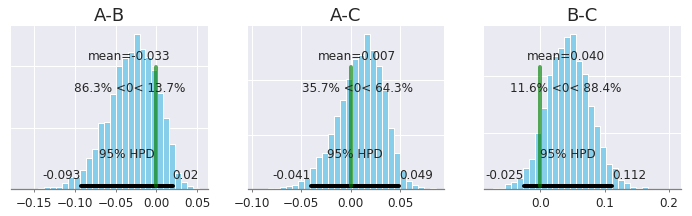

In [13]:
# 差の分布を確認
n_c = len(list(itertools.combinations(np.arange(0, len(lst_buyer)), 2)))
n_col = 3
n_row = math.ceil(n_c/n_col)
fig = plt.figure(figsize=(12, 3*n_row))
ax = fig.subplots(n_row, n_col)
if n_row == 1:
    ax = ax[np.newaxis, :]

cnt=0
for (i,j) in itertools.combinations(np.arange(0, n_buyer), 2):
    theta_diff = trace_sep['theta'][:, i] - trace_sep['theta'][:, j]
    pm.plot_posterior(theta_diff, ref_val=0, ax=ax[int(cnt/n_col), int(cnt%n_col)])
    ax[int(cnt/n_col), int(cnt%n_col)].set_title('{}-{}'.format(buyer_cat[i], buyer_cat[j]))
    cnt+=1
plt.savefig('buyer_effect_diff_isomodel.png')

## 階層モデルとして、全体を統括するパラメータがあると仮定
- 真の出現率を決めるパラメータがあるはず
- 購入者毎の運によって↑のパラメータに基づいたパラメータがサンプルされる
- エンゼルの出現は確率$\theta_i$の二項分布
- $\theta$の事前分布はベータ分布
- ベータ分布のパラメータに事前分布を設定

### 推論

In [14]:
with pm.Model() as model_h:
    alpha = pm.HalfCauchy('alpha', beta=10)
    beta = pm.HalfCauchy('beta', beta=10)
    
    theta = pm.Beta('theta', alpha=alpha, beta=beta, shape=len(set(buyer_idx)))
    
    angel = pm.Binomial('angel', n=total_counts[lst_buyer], p=theta[lst_buyer], observed=angel_counts[lst_buyer])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta, beta, alpha]
100%|██████████| 5500/5500 [00:12<00:00, 432.62it/s]
There were 260 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/tok41/workspace/tech_book/env_tb/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12e503eb8>,
      dtype=object)

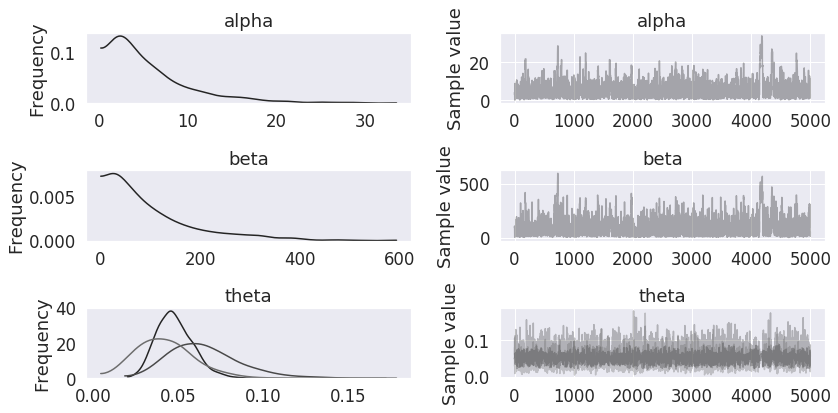

In [15]:
n_sample = 5000
with model_h:
    trace_h = pm.sample(n_sample, chains=1, random_seed=100)
pm.traceplot(trace_h)

### 事後分布の可視化

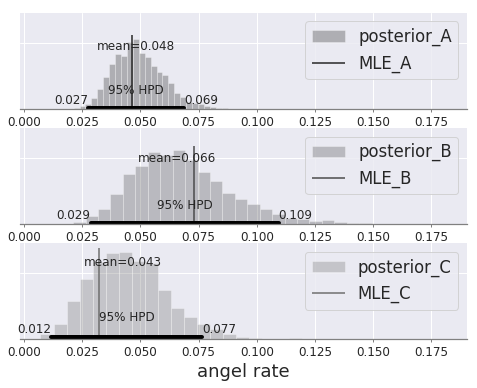

In [16]:
fig = plt.figure(figsize=(8, 6))
ax = fig.subplots(3, 1, sharex=True, sharey=True)

for idx in np.arange(0, len(set(buyer_idx))):
    pm.plot_posterior(trace_h['theta'][:,idx], 
                      color=color_list[idx%len(color_list)], alpha=0.3, 
                      ax=ax[idx], label='posterior_{}'.format(buyer_cat[idx]))
    xmin, xmax, ymin, ymax = ax[idx].axis()
    ax[idx].vlines(theta_mle[idx], ymin, ymax, 
                   colors=color_list[idx%len(color_list)], 
                   label='MLE_{}'.format(buyer_cat[idx]))
    ax[idx].legend()
ax[idx].set_xlabel('angel rate')

plt.savefig('buyer_effect_hierarchy_post.png')

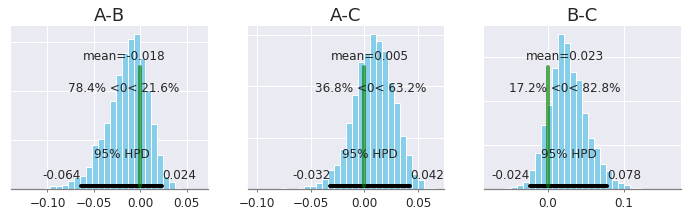

In [17]:
# 差の分布を確認
n_c = len(list(itertools.combinations(np.arange(0, len(lst_buyer)), 2)))
n_col = 3
n_row = math.ceil(n_c/n_col)
fig = plt.figure(figsize=(12, 3*n_row))
ax = fig.subplots(n_row, n_col)
if n_row == 1:
    ax = ax[np.newaxis, :]

cnt=0
for (i,j) in itertools.combinations(np.arange(0, len(lst_buyer)), 2):
    theta_diff = trace_h['theta'][:, i] - trace_h['theta'][:, j]
    pm.plot_posterior(theta_diff, ref_val=0, ax=ax[int(cnt/n_col), int(cnt%n_col)])
    ax[int(cnt/n_col), int(cnt%n_col)].set_title('{}-{}'.format(buyer_cat[i], buyer_cat[j]))
    cnt+=1
plt.savefig('buyer_effect_diff_h2model.png')

Text(0.5, 0, '$\\theta_{prior}$')

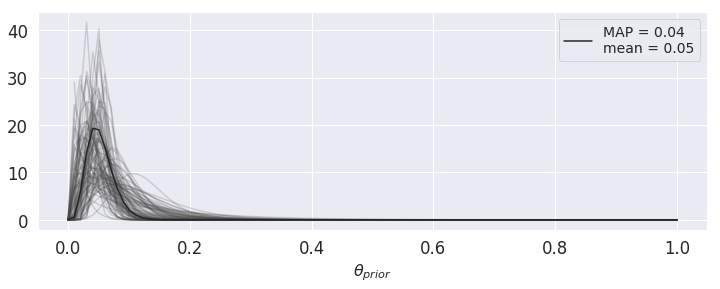

In [18]:
# thetaの事前分布
fig = plt.figure(figsize=(12, 4))
ax = fig.subplots(1,1)

x = np.linspace(0, 1, 100)
for i in np.random.randint(0, n_sample, size=100):
    pdf = stats.beta(trace_h['alpha'][i], trace_h['beta'][i]).pdf(x)
    ax.plot(x, pdf,  'C1', alpha=0.2)

dist = stats.beta(trace_h['alpha'].mean(), trace_h['beta'].mean())
pdf = dist.pdf(x)
map_h = x[np.argmax(pdf)]
mean = dist.moment(1)

ax.plot(x, pdf, label='MAP = {:.2f}\nmean = {:.2f}'.format(map_h, mean))

ax.legend(fontsize=14)
ax.set_xlabel('$\\theta_{prior}$', fontsize=16)
# plt.savefig('buyer_effect_prior_h2model.png')


## 購入者の性質を加える
- 真の出現率は決まっているはず(真の確率を$p$とする)
- 購入者毎の運の要素が入ってくる（不正行為かも、独自の購入戦略があるのかも）可能性がある
  - 購入者毎の特性を個人差$u_i$とする
- エンゼルの出現は確率$\theta_i$の二項分布
- 確率$\theta_i$は以下のロジットリンク関数で線形モデルを仮定
$$
logit(\theta_i) = p + u_i
$$

- $p$、$u_i$は正規分布を事前分布とする

### 推論

In [19]:
with pm.Model() as model_reg:
    su = pm.HalfNormal('su', sd=10)
    beta = pm.Normal('beta', mu=0, sd=10)
    u = pm.Normal('u', mu=0, sd=su, shape=len(set(buyer_idx)))
    
    angel = pm.Binomial('angel', 
                        n=total_counts[lst_buyer], 
                        p=pm.math.sigmoid(beta+u[lst_buyer]), observed=angel_counts[lst_buyer])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [u, beta, su]
100%|██████████| 5500/5500 [00:07<00:00, 747.49it/s]
There were 174 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5814555373305916, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks
/Users/tok41/workspace/tech_book/env_tb/lib/python3.7/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12d6db400>,
      dtype=object)

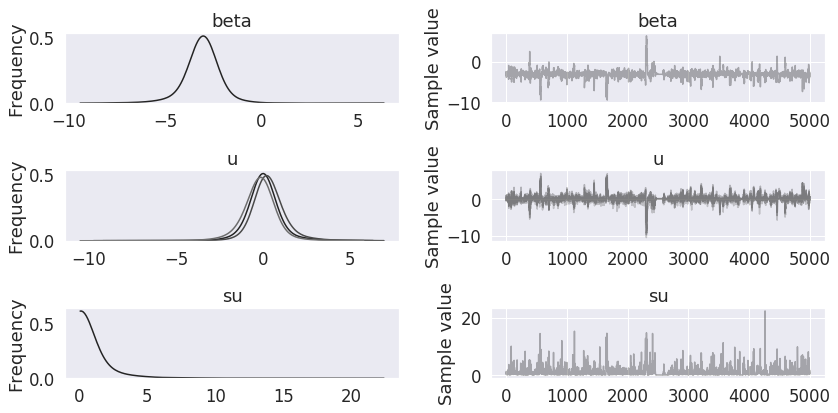

In [20]:
n_sample = 5000
with model_reg:
    trace_reg = pm.sample(n_sample, chains=1, random_seed=100)
pm.traceplot(trace_reg)

### 「運」の量の比較

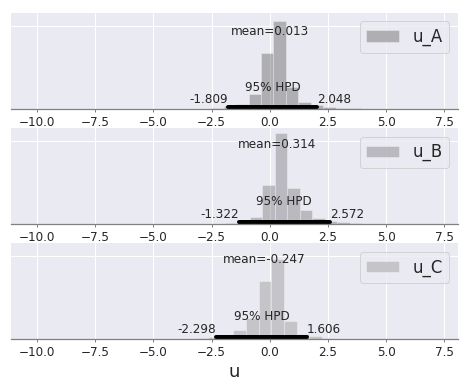

In [21]:
fig = plt.figure(figsize=(8, 6))
ax = fig.subplots(3, 1, sharex=True, sharey=True)

for idx in np.arange(0, len(theta_mle)):
    pm.plot_posterior(trace_reg['u'][:,idx], 
                      color=color_list[idx%len(color_list)], 
                      alpha=0.3, ax=ax[idx], label='u_{}'.format(buyer_cat[idx]))
    ax[idx].legend()
ax[idx].set_xlabel('u')

plt.savefig('buyer_effect_reg_post.png')

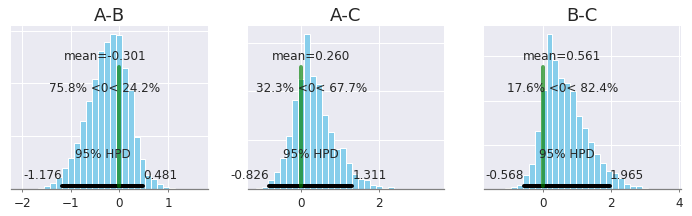

In [22]:
# 差の分布を確認
n_c = len(list(itertools.combinations(np.arange(0, 3), 2)))
n_col = 3
n_row = math.ceil(n_c/n_col)
fig = plt.figure(figsize=(12, 3*n_row))
ax = fig.subplots(n_row, n_col)
if n_row == 1:
    ax = ax[np.newaxis, :]

cnt=0
for (i,j) in itertools.combinations(np.arange(0, 3), 2):
    u_diff = trace_reg['u'][:, i] - trace_reg['u'][:, j]
    pm.plot_posterior(u_diff, ref_val=0, ax=ax[int(cnt/n_col), int(cnt%n_col)])
    ax[int(cnt/n_col), int(cnt%n_col)].set_title('{}-{}'.format(buyer_cat[i], buyer_cat[j]))
    cnt+=1
plt.savefig('buyer_effect_diff_h1model.png')

### 基準出現確率の推論

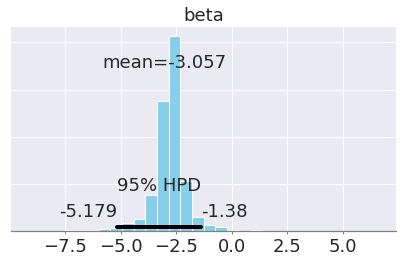

In [23]:
pm.plot_posterior(trace_reg, varnames=['beta'])

In [24]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [25]:
post_min = pm.summary(trace_reg).loc['beta', 'hpd_2.5']
post_mean = pm.summary(trace_reg).loc['beta', 'mean']
post_max = pm.summary(trace_reg).loc['beta', 'hpd_97.5']
print('{} < {} < {}'.format(sigmoid(post_min), sigmoid(post_mean), sigmoid(post_max)))

0.005603976859429278 < 0.04493454996101389 < 0.20106279524693504


0.045000542244349254


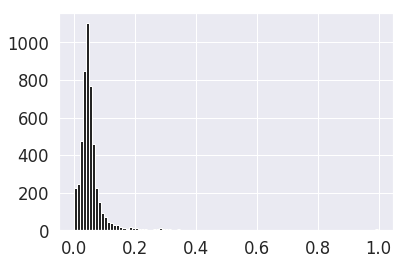

In [26]:
ret = plt.hist(sigmoid(trace_reg['beta']), bins=100)
max_idx = ret[0].argmax()
map_p = np.mean(ret[1][max_idx:max_idx+2])
print(map_p)

(0, 0.4)

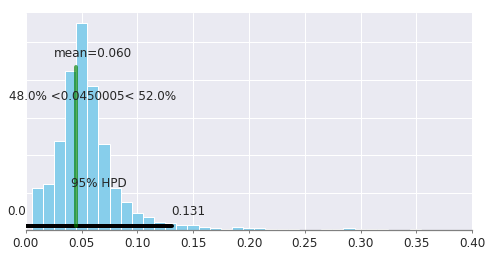

In [27]:
fig = plt.figure(figsize=(8, 4))
ax = fig.subplots(1, 1)

pm.plot_posterior(sigmoid(trace_reg['beta']), ref_val=map_p, bins=100, ax=ax)
ax.set_xlim(0, 0.4)